In [1]:
#from pnp import poisson_solver, run_solver
import numpy as np
import os, sys, re, glob
from dolfin import *
from __future__ import print_function
from fenics import *
import pickle
from numpy.random import rand
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
font = {'family' : 'Times New Roman',
        'weight' : 'regular',
        'size'   : 16}

mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rc('axes', linewidth=2)
mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['xtick.major.size'] = 20                                                                                                                                     
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

def save_obj(obj, name ):
    with open(name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)
    
c_0 = load_obj('initial_c0.pkl')

In [2]:
# Load Mesh
loc = '../'
mesh = Mesh(loc+'mesh.xml');
cd=MeshFunction('size_t',mesh,loc+'mesh_physical_region.xml')
fd=MeshFunction('size_t',mesh,loc+'mesh_facet_region.xml')

## Test Poisson

Solving linear variational problem.


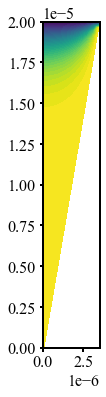

In [3]:
# Test poisson (steady state heat eq) solve
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
#u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)
phi_D = Expression('0 + 0*x[0]*x[0] + 0*x[1]*x[1]', degree=2)
phi_L = Expression('1 + 0*x[0]*x[0] + 0*x[1]*x[1]', degree=2)

def boundary(x, on_boundary):
    return on_boundary

phi = TrialFunction(V)
v = TestFunction(V)

# Radial
r = Expression('x[0]', degree=1)
#a = (Dx(phi,0)*Dx(v,0) + Dx(phi,1)*Dx(v,1))*r*dx()
a = (dot(grad(phi),grad(v)))*r*dx()
f = Constant(0.0)
#g = Expression('-4*x[1]', degree=1)
g = Expression('0.0', degree=1)

tol = 1E-14
L = f*v*dx - g*v*ds
def boundary_1(x, on_boundary):
    return on_boundary and near(x[1], 0, tol)

def boundary_2(x, on_boundary):
    return on_boundary and near(x[0], 1e-7, tol)# and (x[1] < 1e-7))

def boundary_3(x, on_boundary):
    return on_boundary and (1e-7 < x[0] < 2e-7)

def boundary_4(x, on_boundary):
    return on_boundary and (2e-7 < x[0] < 3.5e-6)

def boundary_5(x, on_boundary):
    return on_boundary and near(x[1], 2e-5, tol)

bc_1= DirichletBC(V, phi_D, boundary_1)
bc_2= DirichletBC(V, phi_L, boundary_2)
bc_3= DirichletBC(V, phi_L, boundary_3)
bc_4= DirichletBC(V, phi_L, boundary_4)
bc_5= DirichletBC(V, phi_D, boundary_5)
bcs = [bc_1, bc_2, bc_3, bc_4, bc_5]
#bcs = [bc_z]

'''
# Cartesian
f = Constant(-6.0)
a = dot(grad(u), grad(v))*dx
L = f*v*dx
bcs = DirichletBC(V, u_D, boundary)
'''

# Compute solution
phi = Function(V)
solve(a == L, phi, bcs)

# Plot solution and mesh
plot(phi)
#plot(mesh)
#interactive()

In [ ]:
def save_obj(obj, name ):
    with open(name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)
c_0 = load_obj('initial_c0.pkl')

 11: r (abs) = 2.400e+20 (tol = 1.000e-10) r (rel) = 1.852e+17 (tol = 1.000e-09)
  Newton iteration 12: r (abs) = 5.999e+19 (tol = 1.000e-10) r (rel) = 4.630e+16 (tol = 1.000e-09)
  Newton iteration 13: r (abs) = 1.500e+19 (tol = 1.000e-10) r (rel) = 1.158e+16 (tol = 1.000e-09)
  Newton iteration 14: r (abs) = 3.749e+18 (tol = 1.000e-10) r (rel) = 2.894e+15 (tol = 1.000e-09)
  Newton iteration 15: r (abs) = 9.373e+17 (tol = 1.000e-10) r (rel) = 7.235e+14 (tol = 1.000e-09)
  Newton iteration 16: r (abs) = 2.343e+17 (tol = 1.000e-10) r (rel) = 1.809e+14 (tol = 1.000e-09)
  Newton iteration 17: r (abs) = 5.858e+16 (tol = 1.000e-10) r (rel) = 4.522e+13 (tol = 1.000e-09)
  Newton iteration 18: r (abs) = 1.465e+16 (tol = 1.000e-10) r (rel) = 1.130e+13 (tol = 1.000e-09)
  Newton iteration 19: r (abs) = 3.661e+15 (tol = 1.000e-10) r (rel) = 2.826e+12 (tol = 1.000e-09)
  Newton iteration 20: r (abs) = 9.154e+14 (tol = 1.000e-10) r (rel) = 7.065e+11 (tol = 1.000e-09)
  Newton iteration 21: r (ab

In [83]:
error_L2 = errornorm(phi_D, phi, 'L2')

# Compute maximum error at vertices
vertex_values_phi_D = phi_D.compute_vertex_values(mesh)
vertex_values_phi = phi.compute_vertex_values(mesh)

error_max = np.max(np.abs(vertex_values_phi_D - vertex_values_phi))

# Print errors
print('error_L2  =', error_L2)
print('error_max =', error_max)

*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.error_L2  =
 0.24739740449380657
error_max = 0.5912211691647401


## Test coupled PNP

In [66]:
## Constants Radial
z_1, z_2, z_3, z_4 = 1, -1, 3, 2 # Charge numbers K+, Cl-, Ru3+, Ru2+
eps = 80
eps0 = 8.854187e-12 # Vacuum permittivity F/m
e = 1.60218e-19 # Coulombs 
kbT = 0.0259 # eV, room temp
F = 96485.332 # C/mol
Eo = -0.07
D_o, D_r = 6.5e-10, 6.5e-10 # Diff constants (m^2/s)
a = (1/kbT)
b = a*(F/(eps*eps0))
#a, b = 1, 10e14
eta_list = np.linspace(-0.5, 0.5, 30)
Vapp_list = eta_list + Eo
idx = 0
phi_z0 = 1.0

## initialize phi
V_phi = FunctionSpace(mesh, 'P', 1)

phi_D = Expression(str(0.0), degree=1)
phi_L = Expression(str(phi_z0), degree=1)

def boundary(x, on_boundary):
    return on_boundary

phi = TrialFunction(V_phi)
v = TestFunction(V_phi)


## initialize conc
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1, P1])
V_c = FunctionSpace(mesh, element)

c_ruhex = 2 #mM
c_KCl = 100 #mM
# Note 1mM = 1mol/m3 (SI units)
c_a = Expression(str(c_KCl), degree=1)
c_b = Expression(str(z_1*c_KCl + z_3*c_ruhex), degree=1)
c_c = Expression(str(c_ruhex), degree=1)
c_d = Expression(str(0.0), degree=1)

q_1, q_2, q_3, q_4 = TestFunctions(V_c)
c = Function(V_c)
c_1, c_2, c_3, c_4 = split(c)


## BCs
tol = 1E-14
def boundary_1(x, on_boundary):
    return on_boundary and near(x[1], 0, tol)

def boundary_2(x, on_boundary):
    return on_boundary and near(x[0], 1e-7, tol)# and (x[1] < 1e-7))

def boundary_3(x, on_boundary):
    return on_boundary and (1e-7 < x[0] < 2e-7)

def boundary_4(x, on_boundary):
    return on_boundary and (2e-7 < x[0] < 3.5e-6)

def boundary_5(x, on_boundary):
    return on_boundary and near(x[1], 2e-5, tol)

# phi BCs
bc_1= DirichletBC(V_phi, phi_D, boundary_5)
bc_2= DirichletBC(V_phi, phi_L, boundary_1)
#bcs_phi = [bc_1, bc_2] # All BCs are Neumann
bcs_phi = [bc_1]

# conc BCs
bc_5a= DirichletBC(V_c.sub(0), c_a, boundary_5)
bc_5b= DirichletBC(V_c.sub(1), c_b, boundary_5)
bc_5c= DirichletBC(V_c.sub(2), c_c, boundary_5)
bc_5d= DirichletBC(V_c.sub(3), c_d, boundary_5)
bcs_c = [bc_5a, bc_5b, bc_5c, bc_5d]

## Different Neumann BC for bottom BC
# create a mesh function which assigns an unsigned integer (size_t) to each edge
mf = MeshFunction("size_t", mesh, 1) # 3rd argument is dimension of an edge
mf.set_all(0) # initialize the function to zero
class BottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0, tol) and on_boundary

bottomboundary = BottomBoundary() # instantiate it

# use this bottomboundary object to set values of the mesh function to 1 in the subdomain
bottomboundary.mark(mf, 1)

# define a new measure ds based on this mesh function
ds = Measure("ds", domain=mesh, subdomain_data=mf)
#ds = Measure("ds")(subdomain_data=mf)

### Compute solution
## Define problem for phi
r = Expression('x[0]', degree=1)
nabla_phi = (z_1*c_1 + z_2*c_2 + z_3*c_3 + z_4*c_4)
g = Expression('0.0', degree=1)
F_phi = (dot(grad(phi),grad(v)))*r*dx()
L_phi = (F/(eps*eps0))*nabla_phi*v*r*dx() + g*v*r*ds()
phi = Function(V_phi)
solve(F_phi == L_phi, phi, bcs_phi)

## Define problem for conc
r = Expression('x[0]', degree=1)
#f = Constant(0.0)
#g = Expression('-4*x[1]', degree=1)
g_1 = Expression('0.0', degree=1)
g_2 = Expression('0.0', degree=1)
g_3 = Expression('0.0', degree=1)
g_4 = Expression('0.0', degree=1)
n = FacetNormal(mesh)
#m1 = dot(grad(c_3), n)
#m1 = Dx(c_3,1) does not give correct solution
kox, kred = BV_rates(1e-3, -0.07, A=1.0, Vapp=Vapp_list[idx])
m1 = -(kred*c_3 - kox*c_4)/D_o # Rate theory input
m2 = dot(grad(c_4), n)
F_c = ((dot(grad(c_1), grad(q_1))) - ((z_1*a)*(dot(grad(c_1), grad(phi)))*q_1))*r*dx() \
    + ((dot(grad(c_2), grad(q_2))) - ((z_2*a)*(dot(grad(c_2), grad(phi)))*q_2))*r*dx() \
    + ((dot(grad(c_3), grad(q_3))) - ((z_3*a)*(dot(grad(c_3), grad(phi)))*q_3))*r*dx() \
    + ((dot(grad(c_4), grad(q_4))) - ((z_4*a)*(dot(grad(c_4), grad(phi)))*q_4))*r*dx() \
    + ((z_1*c_1*q_1 + z_2*c_2*q_2 + z_3*c_3*q_3 + z_4*c_4*q_4)*b*nabla_phi)*r*dx() \
    - g_1*q_1*r*ds() - g_2*q_2*r*ds() - g_3*q_3*r*ds(0) - g_4*q_4*r*ds(0) \
    - m1*q_3*r*ds(1) + (D_o/D_r)*m1*q_4*r*ds(1)

L_c = 0
#c_0 = load_obj('initial_c0.pkl')
#c.vector()[:] = c_0
c.vector()[:] = c_0.vector()[:]
#c.vector()[:] = test

#c.vector().set_local(rand(c.vector().size())) # For starting calculations
#c.vector().apply("")
solve(F_c == L_c, c, bcs_c)
_c_1, _c_2, _c_3, _c_4 = c.split()

## Plot solution and mesh
plot(_c_3)
#plot(mesh)

c_0 = c.copy()
phi_0 = phi.copy()
print(c.vector()[:])

    Solving linear variational problem.
    No Jacobian form specified for nonlinear variational problem.
    Differentiating residual form F to obtain Jacobian J = F'.
    Solving nonlinear variational problem.
      Newton iteration 0: r (abs) = 1.810e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
      Newton iteration 1: r (abs) = 9.575e-02 (tol = 1.000e-10) r (rel) = 5.290e-01 (tol = 1.000e-09)
      Newton iteration 2: r (abs) = 2.505e+00 (tol = 1.000e-10) r (rel) = 1.384e+01 (tol = 1.000e-09)
      Newton iteration 3: r (abs) = 7.091e-01 (tol = 1.000e-10) r (rel) = 3.918e+00 (tol = 1.000e-09)
      Newton iteration 4: r (abs) = 1.031e+02 (tol = 1.000e-10) r (rel) = 5.698e+02 (tol = 1.000e-09)
      Newton iteration 5: r (abs) = 5.166e+01 (tol = 1.000e-10) r (rel) = 2.854e+02 (tol = 1.000e-09)
      Newton iteration 6: r (abs) = 1.701e+01 (tol = 1.000e-10) r (rel) = 9.401e+01 (tol = 1.000e-09)
      Newton iteration 7: r (abs) = 1.859e+04 (tol = 1.000e-10) r (rel) = 

KeyboardInterrupt: 

In [70]:
phi(0.5e-7, 2e-5)

-2.9362882466022057e-18

In [71]:
point = [0.5e-7, 0e-5]
x = np.array(point)
x_point = Point(*x) 
P1 = FiniteElement('P', triangle, 1)
vec = project(_c_4.dx(1), FunctionSpace(mesh, P1))
vec(x_point)

2.0551027365120977e-09

In [15]:
phi_D = Expression(str(0.0), degree=1)
phi_L = Expression(str(0.05), degree=1)
bc_1= DirichletBC(V_phi, phi_D, boundary_5)
bc_2= DirichletBC(V_phi, phi_L, boundary_1)
bcs_phi = [bc_1, bc_2] # All BCs are Neumann

#phi = TrialFunction(V_phi)
#v = TestFunction(V_phi)


r = Expression('x[0]', degree=1)
nabla_phi = (z_1*c_1 + z_2*c_2 + z_3*c_3 + z_4*c_4)
g = Expression('0.0', degree=1)
F_phi = (dot(grad(phi),grad(v)))*r*dx() - (F/(eps*eps0))*nabla_phi*v*r*dx() - g*v*r*ds()
L_phi = 0
#phi = Function(V_phi)
phi.vector()[:] = phi_0.vector()[:]
solve(F_phi == L_phi, phi, bcs_phi)
print(errornorm(phi_0, phi, 'L2'),'\n')

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.635e-13 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton solver finished in 0 iterations and 0 linear solver iterations.
  *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
0.0 



In [30]:
phi.vector()[:].copy()

array([0.05      , 0.04999491, 0.05      , ..., 0.        , 0.        ,
       0.        ])

In [36]:
errornorm(phi2, phi_0, 'L2')

  *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.


0.0

In [9]:
i_list = []

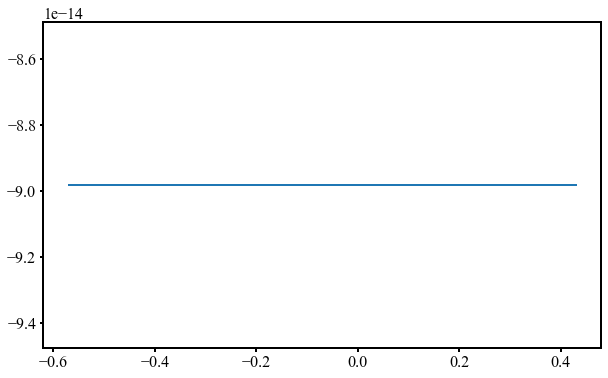

In [249]:
plt.plot(Vapp_list,i_list)

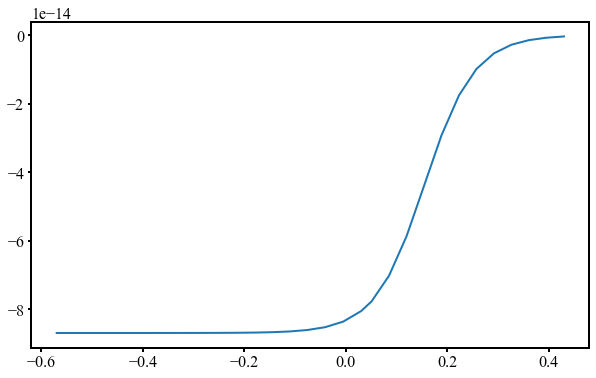

In [246]:
eta_list = np.linspace(-0.5, 0.1, 18)
Vapp_list1 = eta_list + Eo
eta_list = np.linspace(-0.5, 0.5, 30)
Vapp_list2 = eta_list + Eo
x = list(Vapp_list1[:]) + list(Vapp_list2[18:])
plt.plot(x,i_list0)

In [245]:
i_list0 = i_list.copy()

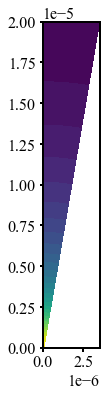

In [76]:
plot(_c_1)
#plot(nabla_phi)

In [241]:
_c_4(0.2e-7, 0e-5)

0.0016134946630910285

In [243]:
point = [0.5e-7, 0e-5]
x = np.array(point)
x_point = Point(*x) 
P1 = FiniteElement('P', triangle, 1)
vec = project(_c_4.dx(1), FunctionSpace(mesh, P1))
vec(x_point)

-197.0498983639006

In [68]:
_c_4(0.5e-7, 0e-5)

0.3809492248213513

In [101]:
c_0.vector()[:]

array([-1.27499711e-65,  2.76358855e-34, -4.23458127e-73, ...,
        1.00000000e+02,  1.00000000e+02,  2.00000000e+00])

In [183]:
e = 1.60218e-19 # Coulombs
a = (1/kbT)
b = a*(F/(eps*eps0))
F = 96485.332 # C/mol
RT = 8.3144*298
b

5259238360651285.0

## Test 2 PNP

      Solving linear variational problem.
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.297e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.206e-13 (tol = 1.000e-10) r (rel) = 9.296e-17 (tol = 1.000e-09)
        Newton solver finished in 1 iterations and 1 linear solver iterations.


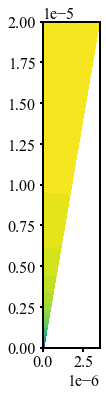

In [68]:
## Constants Radial
z_1, z_2, z_3, z_4 = 1, -1, 3, 2 # Charge numbers K+, Cl-, Ru3+, Ru2+
eps = 80
eps0 = 8.854187e-12 # Vacuum permittivity F/m
e = 1.60218e-19 # Coulombs 
kbT = 0.0259 # eV, room temp
F = 96485.332 # C/mol
D_o, D_r = 6.5e-10, 6.5e-10 # Diff constants (m^2/s)
a = (1/kbT)
b = a*(F/(eps*eps0))
a, b = 1, 10e2
phi_z0 = 0.03

## initialize phi
V_phi = FunctionSpace(mesh, 'P', 1)

phi_D = Expression(str(0.0), degree=1)
phi_L = Expression(str(phi_z0), degree=1)

def boundary(x, on_boundary):
    return on_boundary

phi = TrialFunction(V_phi)
v = TestFunction(V_phi)


## initialize conc
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1, P1])
V_c = FunctionSpace(mesh, element)

c_ruhex = 2 #mM
c_KCl = 100 #mM
# Note 1mM = 1mol/m3 (SI units)
c_a = Expression(str(c_KCl), degree=1)
c_b = Expression(str(z_1*c_KCl + z_3*c_ruhex), degree=1)
c_c = Expression(str(c_ruhex), degree=1)
c_d = Expression(str(0.0), degree=1)

q_1, q_2, q_3, q_4 = TestFunctions(V_c)
c = Function(V_c)
c_1, c_2, c_3, c_4 = split(c)


## BCs
tol = 1E-14
def boundary_1(x, on_boundary):
    return on_boundary and near(x[1], 0, tol)

def boundary_2(x, on_boundary):
    return on_boundary and near(x[0], 1e-7, tol)# and (x[1] < 1e-7))

def boundary_3(x, on_boundary):
    return on_boundary and (1e-7 < x[0] < 2e-7)

def boundary_4(x, on_boundary):
    return on_boundary and (2e-7 < x[0] < 3.5e-6)

def boundary_5(x, on_boundary):
    return on_boundary and near(x[1], 2e-5, tol)

# phi BCs
bc_1= DirichletBC(V_phi, phi_D, boundary_5)
bc_2= DirichletBC(V_phi, phi_L, boundary_1)
#bcs_phi = [bc_r, bc_z]
bcs_phi = [bc_1, bc_2] # All BCs are Neumann

# conc BCs
bc_5a= DirichletBC(V_c.sub(0), c_a, boundary_5)
bc_5b= DirichletBC(V_c.sub(1), c_b, boundary_5)
bc_5c= DirichletBC(V_c.sub(2), c_c, boundary_5)
bc_5d= DirichletBC(V_c.sub(3), c_d, boundary_5)
bcs_c = [bc_5a, bc_5b, bc_5c, bc_5d]

## Different Neumann BC for bottom BC
# create a mesh function which assigns an unsigned integer (size_t) to each edge
mf = MeshFunction("size_t", mesh, 1) # 3rd argument is dimension of an edge
mf.set_all(0) # initialize the function to zero
class BottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0, tol) and on_boundary

bottomboundary = BottomBoundary() # instantiate it

# use this bottomboundary object to set values of the mesh function to 1 in the subdomain
bottomboundary.mark(mf, 1)

# define a new measure ds based on this mesh function
ds = Measure("ds", domain=mesh, subdomain_data=mf)
#ds = Measure("ds")(subdomain_data=mf)

### Compute solution
## Define problem for phi
r = Expression('x[0]', degree=1)
nabla_phi = (z_1*c_1 + z_2*c_2 + z_3*c_3 + z_4*c_4)
g = Expression('0.0', degree=1)
F_phi = (dot(grad(phi),grad(v)))*r*dx()
L_phi = (F/(eps*eps0))*nabla_phi*v*r*dx() + g*v*r*ds()
phi = Function(V_phi)
phi.vector().set_local(rand(phi.vector().size())) # For starting calculations
phi.vector().apply("")
#phi.vector()[:] = phi_0.vector()[:] # Set inital condition
solve(F_phi == L_phi, phi, bcs_phi)

## Define problem for conc
r = Expression('x[0]', degree=1)
#f = Constant(0.0)
#g = Expression('-4*x[1]', degree=1)
g_1 = Expression('0.0', degree=1)
g_2 = Expression('0.0', degree=1)
g_3 = Expression('0.0', degree=1)
g_4 = Expression('0.0', degree=1)
n = FacetNormal(mesh)
#m1 = dot(grad(c_3), n)
#m1 = Dx(c_3,1) does not give correct solution
kox, kred = BV_rates(1e-3, -0.07, Vapp=0.0)
m1 = -(kred*c_3 - kox*c_4)/D_o # Rate theory input
m2 = dot(grad(c_4), n)
F_c = ((dot(grad(c_1), grad(q_1))) - ((z_1*a)*div(c_1*grad(phi))*q_1))*r*dx() \
    + ((dot(grad(c_2), grad(q_2))) - ((z_2*a)*div(c_2*grad(phi))*q_2))*r*dx() \
    + ((dot(grad(c_3), grad(q_3))) - ((z_3*a)*div(c_3*grad(phi))*q_3))*r*dx() \
    + ((dot(grad(c_4), grad(q_4))) - ((z_4*a)*div(c_4*grad(phi))*q_4))*r*dx() \
    - g_1*q_1*r*ds() - g_2*q_2*r*ds() - g_3*q_3*r*ds(0) - g_4*q_4*r*ds(0) \
    - m1*q_3*r*ds(1) + (D_o/D_r)*m1*q_4*r*ds(1)

L_c = 0
#c.vector()[:] = c_0.vector()[:]
c.vector().set_local(rand(c.vector().size())) # For starting calculations
c.vector().apply("")

solve(F_c == L_c, c, bcs_c)
_c_1, _c_2, _c_3, _c_4 = c.split()

## Plot solution and mesh
plot(_c_3)
#plot(mesh)

c_0 = c.copy()
phi_0 = phi.copy()

In [70]:
point = [1e-7, 0.3e-7]
x = np.array(point)
x_point = Point(*x) 
P1 = FiniteElement('P', triangle, 1)
vec = project(_c_4.dx(0), FunctionSpace(mesh, P1))
vec(x_point)

-12.652902593195563

In [42]:
phi(0.5e-7, 0e-5)

1.0

In [47]:
# Finding optimal phi(z=0)
err_list = []
phiz0 = 1.0
count = 1
error_L2 = 100
#for j in range(20):
while error_L2 > 1e-12:    
    #phi.assign(phi_0)
    #c.assign(c_0)
    c_1, c_2, c_3, c_4 = split(c)

    # phi BCs
    phi_D = Expression(str(0.0), degree=1)
    phi_L = Expression(str(phiz0), degree=1)
    bc_1= DirichletBC(V_phi, phi_D, boundary_5)
    bc_2= DirichletBC(V_phi, phi_L, boundary_1)
    bcs_phi = [bc_1, bc_2] # All BCs are Neumann
    
    r = Expression('x[0]', degree=1)
    nabla_phi = (z_1*c_1 + z_2*c_2 + z_3*c_3 + z_4*c_4)
    g = Expression('0.0', degree=1)
    F_phi = (dot(grad(phi),grad(v)))*r*dx() - (F/(eps*eps0))*nabla_phi*v*r*dx() - g*v*r*ds()
    L_phi = 0
    phi.vector()[:] = phi_0.vector()[:]
    solve(F_phi == L_phi, phi, bcs_phi)

    g_1 = Expression('0.0', degree=1)
    g_2 = Expression('0.0', degree=1)
    g_3 = Expression('0.0', degree=1)
    g_4 = Expression('0.0', degree=1)
    n = FacetNormal(mesh)
    #m1 = dot(grad(c_3), n)
    #m1 = Dx(c_3,1) does not give correct solution
    kox, kred = BV_rates(1e-3, -0.07, Vapp=0.0)
    m1 = -(kred*c_3 - kox*c_4)/D_o # Rate theory input
    m2 = dot(grad(c_4), n)
    F_c = ((dot(grad(c_1), grad(q_1))) - ((z_1*a)*div(c_1*grad(phi))*q_1))*r*dx() \
        + ((dot(grad(c_2), grad(q_2))) - ((z_2*a)*div(c_2*grad(phi))*q_2))*r*dx() \
        + ((dot(grad(c_3), grad(q_3))) - ((z_3*a)*div(c_3*grad(phi))*q_3))*r*dx() \
        + ((dot(grad(c_4), grad(q_4))) - ((z_4*a)*div(c_4*grad(phi))*q_4))*r*dx() \
        - g_1*q_1*r*ds() - g_2*q_2*r*ds() - g_3*q_3*r*ds(0) - g_4*q_4*r*ds(0) \
        - m1*q_3*r*ds(1) + (D_o/D_r)*m1*q_4*r*ds(1)

    L_c = 0
    c.vector()[:] = c_0.vector()[:]
    solve(F_c == L_c, c, bcs_c)

    error_L2 = errornorm(phi_0, phi, 'L2')
    err_list.append(error_L2)
    print(count, error_L2, '\n')
    c_0 = c.copy()
    phi_0 = phi.copy()
    count+=1
#plot(phi)

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.100e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.460e-17 (tol = 1.000e-10) r (rel) = 2.237e-13 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.831e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.889e-17 (tol = 1.000e-10) r (rel) = 1.031e-11 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
1 0.017528492891435283 

No Jacobian form specified 

In [56]:
err_list

[0.002923719342500361,
 0.002923800425968854,
 0.0013457875886235201,
 0.002475362110975811,
 0.0012151468710849378,
 0.014521127077601214,
 0.014544908396596983,
 0.0001473961580247041,
 0.009777886061500143,
 0.009673624275556077]

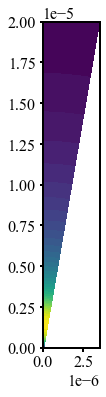

In [55]:
# Finding optimal phi(z=0)
err_list = []
count = 1
error_L2 = 100
eta_list = np.linspace(-0.5, 0.1, 18)
Vapp_list = eta_list + Eo
#Vapp_list = eta_list

# phi solve initial
phi_D = Expression(str(0.0), degree=1)
phi_L = Expression(str(10), degree=1)
bc_1= DirichletBC(V_phi, phi_D, boundary_5)
bc_2= DirichletBC(V_phi, phi_L, boundary_1)
bcs_phi = [bc_1, bc_2] # All BCs are Neumann
    
phi_vec = phi_0.vector()[:].copy()
r = Expression('x[0]', degree=1)
nabla_phi = (z_1*c_1 + z_2*c_2 + z_3*c_3 + z_4*c_4)
g = Expression('0.0', degree=1)
F_phi = (dot(grad(phi),grad(v)))*r*dx() - (F/(eps*eps0))*nabla_phi*v*r*dx() - g*v*r*ds()
L_phi = 0
phi.vector()[:] = phi_0.vector()[:]
solve(F_phi == L_phi, phi, bcs_phi)
#print(errornorm(phi_0, phi, 'L2'),'\n')
err = norm(np.array(phi_0.vector()[:] - phi_vec))
print(count-1, err)
phi_0 = phi.copy()

#for j in range(20):
while err > 1e-12:    
    #phi.assign(phi_0)
    #c.assign(c_0)
    c_1, c_2, c_3, c_4 = split(c)

    g_1 = Expression('0.0', degree=1)
    g_2 = Expression('0.0', degree=1)
    g_3 = Expression('0.0', degree=1)
    g_4 = Expression('0.0', degree=1)
    n = FacetNormal(mesh)
    #m1 = dot(grad(c_3), n)
    #m1 = Dx(c_3,1) does not give correct solution
    kox, kred = BV_rates(1e-3, -0.07, A=1.0, Vapp=Vapp_list[16])
    m1 = -(kred*c_3 - kox*c_4)/D_o # Rate theory input
    m2 = dot(grad(c_4), n)
    F_c = ((dot(grad(c_1), grad(q_1))) - ((z_1*a)*(dot(grad(c_1), grad(phi)))*q_1))*r*dx() \
        + ((dot(grad(c_2), grad(q_2))) - ((z_2*a)*(dot(grad(c_2), grad(phi)))*q_2))*r*dx() \
        + ((dot(grad(c_3), grad(q_3))) - ((z_3*a)*(dot(grad(c_3), grad(phi)))*q_3))*r*dx() \
        + ((dot(grad(c_4), grad(q_4))) - ((z_4*a)*(dot(grad(c_4), grad(phi)))*q_4))*r*dx() \
        + ((z_1*c_1*q_1 + z_2*c_2*q_2 + z_3*c_3*q_3 + z_4*c_4*q_4)*b*nabla_phi)*r*dx() \
        - g_1*q_1*r*ds() - g_2*q_2*r*ds() - g_3*q_3*r*ds(0) - g_4*q_4*r*ds(0) \
        - m1*q_3*r*ds(1) + (D_o/D_r)*m1*q_4*r*ds(1)

    L_c = 0
    c.vector()[:] = c_0.vector()[:]
    solve(F_c == L_c, c, bcs_c)

    phi_vec = phi_0.vector()[:].copy()
    nabla_phi = (z_1*c_1 + z_2*c_2 + z_3*c_3 + z_4*c_4)
    g = Expression('0.0', degree=1)
    F_phi = (dot(grad(phi),grad(v)))*r*dx() - (F/(eps*eps0))*nabla_phi*v*r*dx() - g*v*r*ds()
    L_phi = 0
    phi.vector()[:] = phi_0.vector()[:]
    solve(F_phi == L_phi, phi, bcs_phi)
    err = norm(np.array(phi_0.vector()[:] - phi_vec))
    print(count, err)
    error_L2 = errornorm(phi_0, phi, 'L2')
    err_list.append(error_L2)
    
    #print(count, error_L2,'\n')
    c_0 = c.copy()
    phi_0 = phi.copy()
    count+=1
#plot(phi)

c_1, c_2, c_3, c_4 = split(c)
g_1 = Expression('0.0', degree=1)
g_2 = Expression('0.0', degree=1)
g_3 = Expression('0.0', degree=1)
g_4 = Expression('0.0', degree=1)
n = FacetNormal(mesh)
#m1 = dot(grad(c_3), n)
#m1 = Dx(c_3,1) does not give correct solution
kox, kred = BV_rates(1e-3, -0.07, A=1.0, Vapp=Vapp_list[idx])
m1 = -(kred*c_3 - kox*c_4)/D_o # Rate theory input
m2 = dot(grad(c_4), n)
F_c = ((dot(grad(c_1), grad(q_1))) - ((z_1*a)*(dot(grad(c_1), grad(phi)))*q_1))*r*dx() \
    + ((dot(grad(c_2), grad(q_2))) - ((z_2*a)*(dot(grad(c_2), grad(phi)))*q_2))*r*dx() \
    + ((dot(grad(c_3), grad(q_3))) - ((z_3*a)*(dot(grad(c_3), grad(phi)))*q_3))*r*dx() \
    + ((dot(grad(c_4), grad(q_4))) - ((z_4*a)*(dot(grad(c_4), grad(phi)))*q_4))*r*dx() \
    + ((z_1*c_1*q_1 + z_2*c_2*q_2 + z_3*c_3*q_3 + z_4*c_4*q_4)*b*nabla_phi)*r*dx() \
    - g_1*q_1*r*ds() - g_2*q_2*r*ds() - g_3*q_3*r*ds(0) - g_4*q_4*r*ds(0) \
    - m1*q_3*r*ds(1) + (D_o/D_r)*m1*q_4*r*ds(1)

L_c = 0
c.vector()[:] = c_0.vector()[:]
solve(F_c == L_c, c, bcs_c)

_c_1, _c_2, _c_3, _c_4 = c.split()
current = get_current(_c_3, mesh, a_s = 1e-7)
i_list.append(current)
print(Vapp_list[idx], current)
#print(current)

In [40]:
# Save solution to file in VTK format
vtkfile = File('pnp/_c_1.pvd')
vtkfile << _c_1

In [59]:
_c_4(0.5e-7, 0.0e-5)

0.00013145207123800776

In [46]:
error_L2 = errornorm(phi_0, phi, 'L2')
error_L2

*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.


5.641865521856085e-06

In [63]:
point = [0.7e-7, 0e-5]
x = np.array(point)
x_point = Point(*x) 
P1 = FiniteElement('P', triangle, 1)
vec = project(_c_3.dx(1), FunctionSpace(mesh, P1))
vec(x_point)

650676.3046146865

# Test 3 PNP

In [5]:
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1, P1])
V = FunctionSpace(mesh, element)

# Initialize
c_ruhex = 2 #mM
c_KCl = 100 #mM
# Note 1mM = 1mol/m3 (SI units)
z_1, z_2, z_3, z_4 = 1, -1, 3, 2 # Charge numbers K+, Cl-, Ru3+, Ru2+
c_a = Expression(str(c_KCl), degree=1)
c_b = Expression(str(z_1*c_KCl + z_3*c_ruhex), degree=1)
c_c = Expression(str(c_ruhex), degree=1)
c_d = Expression(str(0.0), degree=1)

# c_2 are for Cl- ion known (constrained) by charge neutrality
q_1, q_2, q_3, q_4 = TestFunctions(V)
c = Function(V)
c_1, c_2, c_3, c_4 = split(c)
# Charge neutrality z_2*c_2 = -(z_1*c_1 + z_3*c_3 + z_4*c_4)


Calling FFC just-in-time (JIT) compiler, this may take some time.


No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.297e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.409e-13 (tol = 1.000e-10) r (rel) = 1.086e-16 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


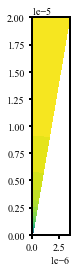

In [6]:
# Constants
z_1, z_2, z_3, z_4 = 1, -1, 3, 2 # Charge numbers
eps = 80
eps0 = 8.854187e-12 # Vacuum permittivity F/m
e = 1.60218e-19 # Coulombs 
kbT = 0.0259 # eV, room temp
F = 96485.332 # C/mol
Eo = -0.07
a = (1/kbT)
b = a*(F/(eps*eps0))
D_o, D_r = 6.5e-10, 6.5e-10 # Diff constants (m^2/s)
a, b = 1, 10e1

## BCs
tol = 1E-14
def boundary_1(x, on_boundary):
    return on_boundary and near(x[1], 0, tol)

def boundary_2(x, on_boundary):
    return on_boundary and near(x[0], 1e-7, tol)# and (x[1] < 1e-7))

def boundary_3(x, on_boundary):
    return on_boundary and (1e-7 < x[0] < 2e-7)

def boundary_4(x, on_boundary):
    return on_boundary and (2e-7 < x[0] < 3.5e-6)

def boundary_5(x, on_boundary):
    return on_boundary and near(x[1], 2e-5, tol)

bc_5a= DirichletBC(V.sub(0), c_a, boundary_5)
bc_5b= DirichletBC(V.sub(1), c_b, boundary_5)
bc_5c= DirichletBC(V.sub(2), c_c, boundary_5)
bc_5d= DirichletBC(V.sub(3), c_d, boundary_5)
bcs = [bc_5a, bc_5b, bc_5c, bc_5d]
#bcs = [bc_5a]

## Different Neumann BC for bottom BC
# create a mesh function which assigns an unsigned integer (size_t) to each edge
mf = MeshFunction("size_t", mesh, 1) # 3rd argument is dimension of an edge
mf.set_all(0) # initialize the function to zero
class BottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0, tol) and on_boundary

bottomboundary = BottomBoundary() # instantiate it

# use this bottomboundary object to set values of the mesh function to 1 in the subdomain
bottomboundary.mark(mf, 1)

# define a new measure ds based on this mesh function
ds = Measure("ds", domain=mesh, subdomain_data=mf)
#ds = Measure("ds")(subdomain_data=mf)


## Weak form
r = Expression('x[0]', degree=1)
nabla_phi = (z_1*c_1 + z_2*c_2 + z_3*c_3 + z_4*c_4)
g_1 = Expression('0.0', degree=1)
g_2 = Expression('0.0', degree=1)
g_3 = Expression('0.0', degree=1)
g_4 = Expression('0.0', degree=1)
n = FacetNormal(mesh)
#m1 = dot(grad(c_3), n)
#m1 = Dx(c_3,1) does not give correct solution
kox, kred = BV_rates(1e-3, -0.07, Vapp=0.0)
m1 = -(kred*c_3 - kox*c_4)/D_o # Rate theory input
#m2 = dot(grad(c_4), n)
F = (dot(grad(c_1), grad(q_1)))*r*dx() \
    + (dot(grad(c_2), grad(q_2)))*r*dx() \
    + (dot(grad(c_3), grad(q_3)))*r*dx() \
    + (dot(grad(c_4), grad(q_4)))*r*dx() \
    + ((z_1*c_1*q_1 + z_2*c_2*q_2 + z_3*c_3*q_3 + z_4*c_4*q_4)*b*nabla_phi)*r*dx() \
    - g_1*q_1*r*ds() - g_2*q_2*r*ds() - g_3*q_3*r*ds(0) - g_4*q_4*r*ds(0) \
    - m1*q_3*r*ds(1) + (D_o/D_r)*m1*q_4*r*ds(1) 
    
#c_4 = c_ruhex - c_3
#L = g*q_1*ds + g*q_2*ds
L = 0
    
c.vector().set_local(rand(c.vector().size())) # For starting calculations
c.vector().apply("")
#c.vector()[:] = c_0.vector()[:]
solve(F == L, c, bcs)
_c_1, _c_2, _c_3, _c_4 = c.split()

# Plot solution and mesh
plot(_c_3)
#plot(mesh)

In [9]:
point = [1e-7, 0.5e-7]
x = np.array(point)
x_point = Point(*x) 
P1 = FiniteElement('P', triangle, 1)
vec = project(_c_3.dx(0), FunctionSpace(mesh, P1))
vec(x_point)

25.09618577136677

In [7]:
c_0 = c.copy()

In [205]:
## Run over eta range
# Constants
z_1, z_2, z_3, z_4 = 1, -1, 3, 2 # Charge numbers
eps = 80
eps0 = 8.854187e-12 # Vacuum permittivity F/m
e = 1.60218e-19 # Coulombs 
kbT = 0.0259 # eV, room temp
F = 96485.332 # C/mol
Eo = -0.07
a = (1/kbT)
b = a*(F/(eps*eps0))
D_o, D_r = 6.5e-10, 6.5e-10 # Diff constants (m^2/s)
a, b = 1, 10e1

## BCs
tol = 1E-14
def boundary_1(x, on_boundary):
    return on_boundary and near(x[1], 0, tol)

def boundary_2(x, on_boundary):
    return on_boundary and near(x[0], 1e-7, tol)# and (x[1] < 1e-7))

def boundary_3(x, on_boundary):
    return on_boundary and (1e-7 < x[0] < 2e-7)

def boundary_4(x, on_boundary):
    return on_boundary and (2e-7 < x[0] < 3.5e-6)

def boundary_5(x, on_boundary):
    return on_boundary and near(x[1], 2e-5, tol)

bc_5a= DirichletBC(V.sub(0), c_a, boundary_5)
bc_5b= DirichletBC(V.sub(1), c_b, boundary_5)
bc_5c= DirichletBC(V.sub(2), c_c, boundary_5)
bc_5d= DirichletBC(V.sub(3), c_d, boundary_5)
bcs = [bc_5a, bc_5b, bc_5c, bc_5d]
#bcs = [bc_5a]

## Different Neumann BC for bottom BC
# create a mesh function which assigns an unsigned integer (size_t) to each edge
mf = MeshFunction("size_t", mesh, 1) # 3rd argument is dimension of an edge
mf.set_all(0) # initialize the function to zero
class BottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0, tol) and on_boundary

bottomboundary = BottomBoundary() # instantiate it

# use this bottomboundary object to set values of the mesh function to 1 in the subdomain
bottomboundary.mark(mf, 1)

# define a new measure ds based on this mesh function
ds = Measure("ds", domain=mesh, subdomain_data=mf)
#ds = Measure("ds")(subdomain_data=mf)

# Calculate
eta_list = np.linspace(-0.5, 0.1, 18)
i_list = []
#Vapp_list = eta_list + Eo
Vapp_list = eta_list

for j in range(len(eta_list)):
    kox, kred = BV_rates(1e-3, Eo, A=0.6, Vapp=Vapp_list[j])
    m1 = -(kred*c_3 - kox*c_4)/D_o # Rate theory input
    
    F = (dot(grad(c_1), grad(q_1)))*r*dx() \
        + (dot(grad(c_2), grad(q_2)))*r*dx() \
        + (dot(grad(c_3), grad(q_3)))*r*dx() \
        + (dot(grad(c_4), grad(q_4)))*r*dx() \
        + ((z_1*c_1*q_1 + z_2*c_2*q_2 + z_3*c_3*q_3 + z_4*c_4*q_4)*b*nabla_phi)*r*dx() \
        - g_1*q_1*r*ds() - g_2*q_2*r*ds() - g_3*q_3*r*ds(0) - g_4*q_4*r*ds(0) \
        - m1*q_3*r*ds(1) + (D_o/D_r)*m1*q_4*r*ds(1)     
    L = 0
    c.vector()[:] = c_0.vector()[:]
    solve(F == L, c, bcs)
    _c_1, _c_2, _c_3, _c_4 = c.split()
    
    i_list.append(get_current(_c_3, mesh, a_s = 1e-7))
    print(j, i_list[j])

No Jacobian form specified for nonlinear variational problem.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Differentiating residual form F to obtain Jacobian J = F'.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.263e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 6.377e-19 (tol = 1.000e-10) r (rel) = 5.050e-13 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
0 -2.90784987595233e-12
No Jacobian form specified for nonlinear variational problem.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Differentiating residual form F to obtain Jacobian J = F'.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.883e-10 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteratio

Differentiating residual form F to obtain Jacobian J = F'.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 7.860e-11 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
14 -1.2144564676267754e-12
No Jacobian form specified for nonlinear variational problem.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Differentiating residual form F to obtain Jacobian J = F'.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.184e-10 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 5.112e-19 (tol = 1.000e-10) r (rel) = 4.319e-09 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
15 -4.509683359717537e-13
No Jacobian form specified for nonlinear vari

Text(0, 0.5, 'i (pA)')

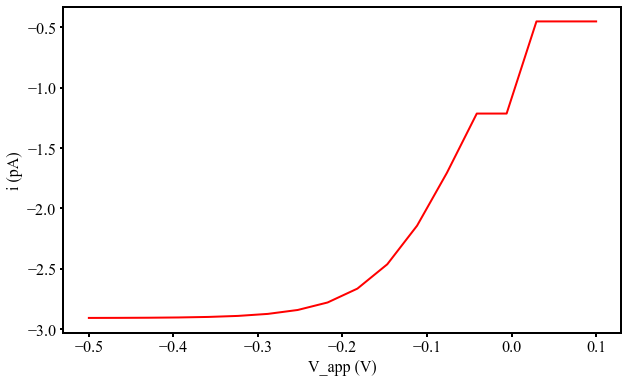

In [206]:
plt.plot(eta_list, np.array(i_list)*1e12, 'r-')
plt.xlabel('V_app (V)')
plt.ylabel('i (pA)')

In [202]:
for i in range(len(eta_list)):
    print(eta_list[i], i_list[i])
np.linspace(-0.5, 0.1, 7)

-0.5 -2.908337359914819e-12
-0.4666666666666667 -2.908256384171233e-12
-0.43333333333333335 -2.908102289555776e-12
-0.4 -2.9078090723479533e-12
-0.3666666666666667 -2.907251204760521e-12
-0.33333333333333337 -2.9061901004859313e-12
-0.3 -2.9041728176994115e-12
-0.26666666666666666 -2.9003413890765228e-12
-0.23333333333333334 -2.893077532412103e-12
-0.2 -2.8793534879765084e-12
-0.16666666666666669 -2.8535912923002294e-12
-0.13333333333333336 -2.8058146136296064e-12
-0.09999999999999998 -2.719172315667866e-12
-0.06666666666666665 -2.568242195249677e-12
-0.033333333333333326 -2.322866111572154e-12
0.0 -1.9654827686491155e-12
0.033333333333333326 -1.520323890669345e-12
0.06666666666666665 -1.520323890669345e-12
0.09999999999999998 -6.752921879631619e-13
0.1333333333333333 -6.752921879631619e-13
0.16666666666666663 -6.752921879631619e-13
0.19999999999999996 -6.752921879631619e-13
0.23333333333333328 -6.752921879631619e-13
0.2666666666666666 -6.752921879631619e-13
0.30000000000000004 -6.7529

array([-5.00000000e-01, -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
       -1.00000000e-01, -5.55111512e-17,  1.00000000e-01])

In [179]:
c_0 = c

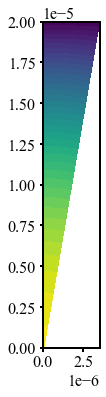

In [156]:
plot(_c_2)

In [192]:
np.linspace(-0.5, 0.5, 11)

array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5])

In [78]:
# Save solution to file in VTK format
vtkfile = File('pnp/_c_3.pvd')
vtkfile << _c_3

# Define functions

In [104]:
def deriv(func, point, mesh, direction=0):
    # point :: List
    x = np.array(point)
    x_point = Point(*x) 
    P1 = FiniteElement('P', triangle, 1)
    vec = project(func.dx(direction), FunctionSpace(mesh, P1))
    return vec, vec(x_point)

In [153]:
point = [0.5e-7, 0e-7]
x = np.array(point)
x_point = Point(*x) 
P1 = FiniteElement('P', triangle, 1)
vec = project(_c_3.dx(1), FunctionSpace(mesh, P1))
vec(x_point)

517373.18879890407

In [151]:
#_c_3(2e-7, 6.88236e-7)
_c_4(2e-7, 1.99e-5)

4.8669271715107226e-05

In [192]:
# create a mesh function which assigns an unsigned integer (size_t) to each edge
mf = MeshFunction("size_t", mesh, 1) # 3rd argument is dimension of an edge
mf.set_all(0) # initialize the function to zero
class BottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0, tol) and on_boundary

bottomboundary = BottomBoundary() # instantiate it

# use this bottomboundary object to set values of the mesh function to 1 in the subdomain
bottomboundary.mark(mf, 1)

# define a new measure ds based on this mesh function
ds = Measure("ds")(domain=mesh, subdomain_data=mf)

In [3]:
def BV_rates(ko, Eo, A=1.0, Vapp=0.0, alpha=0.5):
    kbT = 0.0259
    kox = A*ko*np.exp(-(alpha*(Vapp - Eo))/kbT)
    kred = A*ko*np.exp(-((1-alpha)*(Vapp - Eo))/kbT)
    return kox, kred

In [4]:
def get_current(func, mesh, a_s = 1e-7):
    # func: _c_3 in our case (Ru3+), a_s: 100nm pippete radius
    F = 96485.332
    r = np.linspace(0,a_s,1000)
    Jo_list = []
    vec = project(func.dx(1), FunctionSpace(mesh, P1))
    for j in range(len(r)):
        point = np.array([r[j], 0.0])
        x = np.array(point)
        x_point = Point(*x) 
        Jo = -D_o*vec(x_point)
        Jo_list.append(Jo)
    i = 2*np.pi*F*np.trapz(Jo_list*r, x=r)
    return i
#get_current(_c_3, mesh, a_s = 1e-7)

In [178]:
Eo = -0.07
eta = np.linspace(-0.6, 0.0, 13)

array([-0.67, -0.62, -0.57, -0.52, -0.47, -0.42, -0.37, -0.32, -0.27,
       -0.22, -0.17, -0.12, -0.07])

In [198]:
n = FacetNormal(mesh)
m1 = dot(grad(c_3), n)
m2 = (grad(c_4), n)
Dx(c_3,1)*q_3*r*ds(1)

Form([Integral(Product(Coefficient(FunctionSpace(None, FiniteElement('Lagrange', None, 1)), 2586), Product(Indexed(Grad(Indexed(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), MixedElement(FiniteElement('Lagrange', triangle, 1), FiniteElement('Lagrange', triangle, 1), FiniteElement('Lagrange', triangle, 1), FiniteElement('Lagrange', triangle, 1))), 2556), MultiIndex((FixedIndex(2),)))), MultiIndex((FixedIndex(1),))), Indexed(Argument(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), MixedElement(FiniteElement('Lagrange', triangle, 1), FiniteElement('Lagrange', triangle, 1), FiniteElement('Lagrange', triangle, 1), FiniteElement('Lagrange', triangle, 1))), 0, None), MultiIndex((FixedIndex(2),))))), 'exterior_facet', Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), 1, {}, <dolfin.cpp.mesh.MeshFunctionSizet object at 0x7f8721893670>)])

In [ ]:
# Compute solution
#problem = NonlinearVariationalProblem(F,c,J=derivative(F,c),bcs=bcs)
#solver = NonlinearVariationalSolver(problem)
#stype = 'newton'
#solver.parameters['nonlinear_solver']=stype
#sprms = solver.parameters[stype+'_solver']

# Set maximum iterations:
#sprms['maximum_iterations'] = 100

In [207]:
(D_o/D_r)*m1*q_4*r*ds(1)

1.0

In [92]:
BV_rates(1.0, -0.07, Vapp=0.0)

(0.25889017256861724, 0.25889017256861724)

In [120]:
mf.array()

array([0, 0, 0, ..., 0, 1, 0], dtype=uint64)